# Assignment 7 

## Grade: /100 pts

This notebook contains the questions for Assignment 7. 

Make sure to complete this assignment individually and appropriately reference all external code and documentation used. ***In order for your submission to be valid, you must adhere to the function definitions which have been made (failure to do so will result in a grade of 0). You must upload this completed Jupyter Notebook file as your submission (other file types are not permitted and will result in a grade of 0).*** You are responsible for selecting and importing additional packages.

### Preliminaries

Feel free to add any libraries to the Preliminaries. However, be mindful of every question's restrictions as some may exclude use of some functions.

In [375]:
## perform the necessary imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import recall_score, make_scorer, mean_squared_error, confusion_matrix, precision_score, roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import torch
import time

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data set

In this Assignment you need to download and use "Dataset.csv". 

This dataset is a modified dataset from Kaggle datasets called "Lower Back Pain Symptoms Dataset". Lower back pain can be caused by a variety of problems with any parts of the complex, interconnected network of spinal muscles, nerves, bones, discs or tendons in the lumbar spine.
This data set is about to identify/label a person as abnormal or normal using collected physical spine details/data.



### Question 1: Load Datasets (15pts)

A) Load the "Dataset.csv" file.

B) Encode the output classes `Label` (0: Normal, 1: Abnormal) and separate inputs and outputs (features and target). (2 pts)

C) Split the data into equals-sized training and test sets. Use a random_state = 42, and ensure the `balanced distribution` of labels when splitting data.  

D) How many observations do you have in your training set?  

E) How many observations for each class in your training set?

F) Z-standarize the input features of the training and test sets.

In [376]:
data = pd.read_csv('Dataset.csv')
data['Label'] = data['Label'].map({'Normal': 0, 'Abnormal': 1})

X = data.drop(columns=['Label'])
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

print(f'Number of observations in the training set: {len(X_train)}')
class_distribution_training_set = y_train.value_counts()
print('Class distribution in the training set:')
print(class_distribution_training_set)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Number of observations in the training set: 155
Class distribution in the training set:
Label
1    105
0     50
Name: count, dtype: int64


### Question 2: Logistic Regression (15 pts)

A) Build a L1-regularized logistic regression model to all the training data, and then get the predicted labels for each item of the test set. Tip: use the 'saga' solver for L1 regularization.

B) Print out the precision, recall, and F1-score of the test set.

C) Print out the model execution time (both training and test time) in milliseconds. Please keep two decimal places.

D) Plot ROC curve and report the area under the ROC curve for the test data set. 


Training Time: 5.69605827331543 ms
Precision: 0.897196261682243
Recall: 0.9142857142857143
F1 Score: 0.9056603773584906
Test Time: 0.6420612335205078 ms


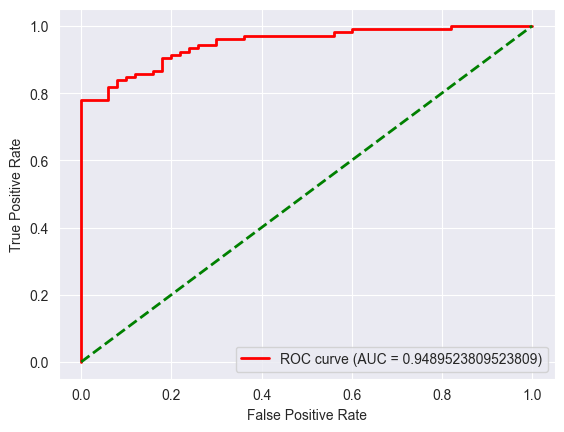

In [377]:
t0 = time.time()
model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
model.fit(X_train_scaled, y_train)
training_time = time.time() - t0
print(f'Training Time: {training_time * 1000} ms')

y_pred = model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

t0 = time.time()
y_pred_test = model.predict(X_test_scaled)
test_time = time.time() - t0
print(f'Test Time: {test_time * 1000} ms')

y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Question3: Neural Network 


### Q3a) Building model (15 pts)

Build a simple neural network model (NN_model1) using PyTorch packages with the features in the data set as the input units and two output units for the two output classes:

* Use a LogSigmoid as your output non-linearity.
* Use the Cross-entropy loss as a training criterion. 
* Use Stochastic gradient descent optimizer with a learning rate of 0.01. 
* Run the optimization for 8000 iterations and record the loss for each iteration. 
* Plot the loss versus iterations.

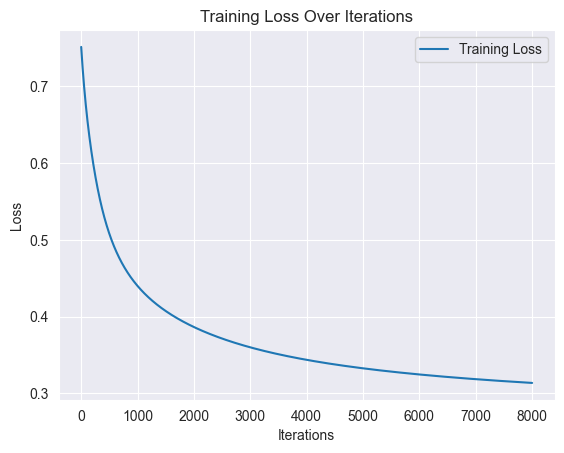

In [378]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

class NN_model1(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(NN_model1, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size)
        self.logsigmoid = torch.nn.LogSigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.logsigmoid(x)
        return x
torch.manual_seed(42)

input_size = X_train_tensor.shape[1]
output_size = 2
num_iterations = 8000
NN_model = NN_model1(input_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(NN_model.parameters(), lr=0.01)

losses = []
for iteration in range(num_iterations):
    outputs = NN_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, num_iterations + 1), losses, label='Training Loss')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Q3b) Prediction (20 pts)

Now use your trained model (NN_model1) to make predictions on the test set.

A) Print out the precision, recall, and F1-score of the test set.

B) Print out the model execution time (both training and test time) in milliseconds. Please keep two decimal places.

C) Plot ROC curve and report the area under the ROC curve for the test data set. 

Test Time: 0.92315673828125 ms
Precision: 0.8434782608695652
Recall: 0.9238095238095239
F1 Score: 0.8818181818181818


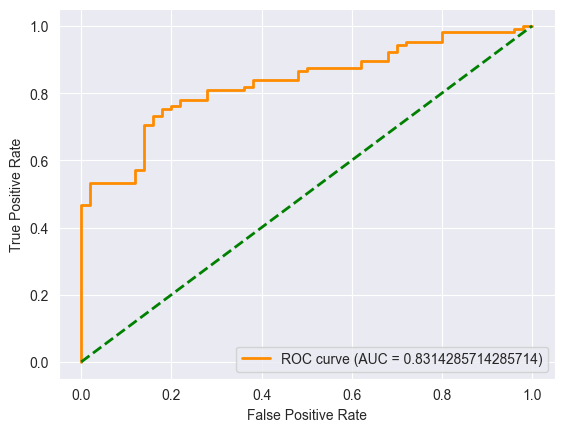

In [379]:
model_path = 'NN_model1.pth'
torch.save(NN_model.state_dict(), model_path)
NN_model = NN_model1(input_size, output_size)
NN_model.load_state_dict(torch.load(model_path))
NN_model.eval()

t0 = time.time()
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
logits = NN_model(X_test_tensor)
y_prob = torch.sigmoid(logits).detach().numpy()
y_prob = y_prob[:, 1]

y_pred = NN_model.forward(X_test_tensor)
y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
test_time = time.time() - t0
print(f'Test Time: {test_time * 1000} ms')

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Q3c) Adding hidden layers (15 pts)
Change the neural network (NN_model2) and add two hidden layers with 100 and 60 units, respectively. Use the LogSigmoid non-linearity for the hidden layers. Leave all the other parameters the same as for Question 3a. Again train for 8000 iterations and plot the loss as a function of the iteration. 

Iteration 0, Loss: 0.6657623052597046
Iteration 1000, Loss: 0.39927151799201965
Iteration 2000, Loss: 0.31423231959342957
Iteration 3000, Loss: 0.2862238585948944
Iteration 4000, Loss: 0.2653330862522125
Iteration 5000, Loss: 0.2422230839729309
Iteration 6000, Loss: 0.2181326299905777
Iteration 7000, Loss: 0.19604754447937012


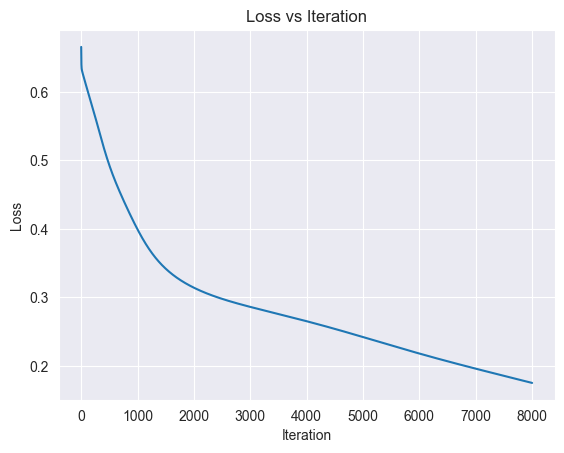

In [380]:
class NN_model2(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(NN_model2, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 100)
        self.logsigmoid1 = torch.nn.LogSigmoid()
        self.fc2 = torch.nn.Linear(100, 60)
        self.logsigmoid2 = torch.nn.LogSigmoid()
        self.fc3 = torch.nn.Linear(60, output_size)

    def forward(self, x):
        x = self.logsigmoid1(self.fc1(x))
        x = self.logsigmoid2(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train_tensor.shape[1]
output_size = 2
learning_rate = 0.01
num_iterations = 8000

NN_model2 = NN_model2(input_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(NN_model2.parameters(), lr=learning_rate)

losses = []
for iteration in range(num_iterations):
    logits = NN_model2(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if iteration % 1000 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

plt.plot(range(num_iterations), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

### Q3d) Prediction and model selection (20 pts)
Now use your trained model in Question 3c (NN_model2) to make predictions on the test set.

A) Print out the precision, recall, and F1-score of the test set.

B) Print out the model execution time (both training and test time) in milliseconds. Please keep two decimal places.

C) Plot ROC curve and report the area under the ROC curve for the test data set. 

__Written answer:__ Compare this model (NN_model2) to the results from Question 2 (Logistic Regression) and 3b (NN_model1), what do you conclude? 

Test Time: 2.5177001953125 ms
Precision: 0.839622641509434
Recall: 0.8476190476190476
F1 Score: 0.8436018957345972


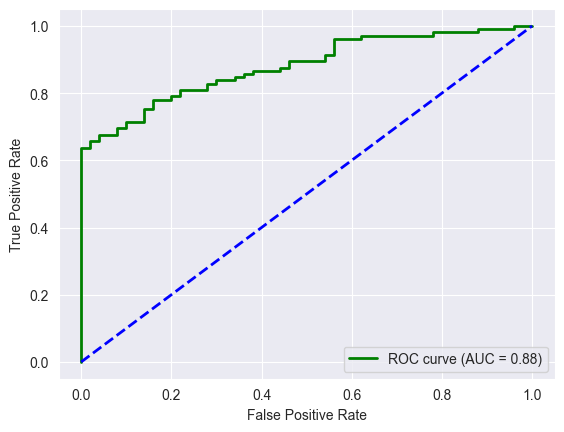

In [381]:
t0 = time.time()
with torch.no_grad():
    logits = NN_model2(X_test_tensor)
    y_prob = torch.softmax(logits, dim=1)[:, 1].detach().numpy()
    y_pred = torch.argmax(logits, dim=1).detach().numpy()

test_time = time.time() - t0
print(f'Test Time: {test_time * 1000} ms')

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

__Written answer:__ NN_model1, Logistic Regression NN_model2 have similar performance in terms of precision, recall, and F1 score. The Logistic Regression model scored slightly better but took longer to train.